# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd # импорт библиотеки pandas
import seaborn as sns # импорт библиотеки seaborn
from pymystem3 import Mystem # импорт библиотеки pymystem3
m = Mystem()

In [2]:
df = pd.read_csv('/datasets/data.csv') # чтение файла с данными и сохранение в df

In [3]:
df.head(5) # получение первых 5 строк таблицы df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [4]:
df.info() # получение общей информации о данных в таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
df.describe() # описание столбцов с числовыми данными.

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


* В столбце `children` присуствует отрицательные значения, а также максимальное значение составляет 20.
* В столбце `days_employed` есть пропущенные значения. Максимальный стаж некорректен.В столбце имеютс отрицательные значения.
* В столбце `total_income` имеются вещественные числа. Возможны пропуски и некорректные значения.

**Вывод**

В исходной таблице 12 столбцов и 21525 строк. Тип данных float64(2), int64(5), object(5).

Согласно документации к данным:

* `children` — количество детей в семье;
* `days_employed` — общий трудовой стаж в днях;
* `dob_years` — возраст клиента в годах;
* `education` — уровень образования клиента;
* `education_id` — идентификатор уровня образования;
* `family_status` — семейное положение;
* `family_status_id` — идентификатор семейного положения;
* `gender` — пол клиента;
* `income_type` — тип занятости;
* `debt` — имел ли задолженность по возврату кредитов;
* `total_income` — ежемесячный доход;
* `purpose` — цель получения кредита.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

В каждой строке таблицы информация о платежеспособности клиента банка. Все колонки рассказывают информацию о клиенте банка.

В таблице встречаются пропуски, отрицательные значения , которые могут повлить на проверку гипотез.

## Шаг 2. Предобработка данных

### Обработка пропусков

In [6]:
df.isna().sum() # подсчёт пропусков

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропуски имеются в колонках `days_employed` и `total_income`. Количество пропусков от общего количества строк составляет более 10 %.

Переводим  значения  стоблца `days_employed` из дней в год.

In [7]:
df['days_employed'] = df['days_employed'] / 365 # перевод значений в столбце 'days_employed' из дней в год 

В связи с тем ,что в столбце `days_employed` имеются отрицательные значения преводим эти значения в положительные с помощью метода abs().

In [8]:
df['days_employed'] = abs(df['days_employed']) # замена отрицательных значений в колонке 'days_employed' методом abs()

Выводим значения колонки `days_employed` с фильтром больше 900. Проверяем количество значений в столбце общий трудовой стаж ,которые сосотавляют более 900 лет.

In [9]:
df[df['days_employed'] >= 900].count() # вывод количества значений колонки 'days_employed' с использованием логического фильтра 

children            3445
days_employed       3445
dob_years           3445
education           3445
education_id        3445
family_status       3445
family_status_id    3445
gender              3445
income_type         3445
debt                3445
total_income        3445
purpose             3445
dtype: int64

3445 значений в колонке общий трудовой стаж в годах имеют некорректные значения. Выведенные значения трудовой стажа составляют более 900 лет.

Некорректные значения обусловлены некоррекном заполнении начала и конец трудового стажа. Указанные значения указаны в днях.

In [10]:
def correct_employed(row):   # функция, которая переводит некорректные значения стажа в года.
    dob_years = row['dob_years']
    days_employed = row['days_employed']
    if days_employed >= dob_years: 
        return days_employed / 24
    else: 
        return days_employed 
    
df['days_employed'] = df.apply(correct_employed, axis=1) # с помощью метода apply()  и функции correct_employed(row) заменяем некорректные значения 

Для заполнения пропушенных значений в колонке `days_employed` используем медиану по типу занятости. 

In [11]:
df.groupby('income_type')['days_employed'].agg(['count']) # вывод группировки данных колонка `income_type` и значения `days_employed`

,count
income_type,
безработный,2
в декрете,1
госслужащий,1312
компаньон,4577
пенсионер,3443
предприниматель,1
сотрудник,10014
студент,1


Медиана будет рассчитана для четырех типов занятости `сотрудник`, `пенсионер`, `компаньон`, `госслужащий`.

In [12]:
for row in df['income_type'].unique(): # заполнение пропусков по одной переменной
    mediana = df.loc[df['income_type'] == row, 'days_employed'].median()
    df.loc[(df['days_employed'].isna()) & (df['income_type'] == row), 'days_employed'] = mediana

In [13]:
df['days_employed'].isna().sum() # подсчет пропусков в  колонке 'days_employed'

0

Пропуски в столбце `days_employed` заменены на медиану по каждому типу занятости.   

Замена пропусков в столбце `total_income` на медиану по двум переменным.

In [14]:
# датафрейм с группированными значениями
medians = (df.groupby(['income_type','education']).agg({'total_income': 'median'}).rename(columns = {'total_income' : 'total_income_median'}))
# объединение с исходным датафреймом
df = df.merge(medians, on = ['income_type','education'])
# заполнение пропусков в столбце 'total_income' на 'total_income_median'
df.loc[df['total_income'].isna(),'total_income'] = df.loc[df['total_income'].isna(),'total_income_median']

In [15]:
df['total_income'].isna().sum() # подсчет пропусков в  колонке 'income_type'

0

In [16]:
df.isna().sum() # подсчёт пропусков после замен

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
total_income_median    0
dtype: int64

**Вывод**

Пропуски оказались в колонках `days_employe` , `total_income`. Для дальнейшего анализа гипотез количество пропусков было более 10 % от всех значений. Это могло повлиять на дальшейшее рассмотрение гипотез. С помощью цикла и метода median() произвели замену пропусков в таблице.

В столбце `days_employed` выявили некорректные данные: отрицательные значения, стаж свыше 1000 лет. Обусловлено , это тем что данные некорректно заносились в таблицу. Данные заменили на корректные значения.

### Замена типа данных

In [17]:
df.info() # получение общей информации о данных в таблице df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children               21525 non-null int64
days_employed          21525 non-null float64
dob_years              21525 non-null int64
education              21525 non-null object
education_id           21525 non-null int64
family_status          21525 non-null object
family_status_id       21525 non-null int64
gender                 21525 non-null object
income_type            21525 non-null object
debt                   21525 non-null int64
total_income           21525 non-null float64
purpose                21525 non-null object
total_income_median    21525 non-null float64
dtypes: float64(3), int64(5), object(5)
memory usage: 2.3+ MB


Замена  типов данных в столбцах `days_employed` и `total_income` на int.

In [18]:
df['total_income'] = df['total_income'].astype('int') # замена вещественных типов данных на целочисленные

In [19]:
df['days_employed'] = df['days_employed'].astype('int') # замена вещественных типов данных на целочисленные

In [20]:
df['debt'] = df['debt'].astype('bool') # замена целочисленный типов данных на булевый тип

In [21]:
df.info() # получение общей информации о данных в таблице df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children               21525 non-null int64
days_employed          21525 non-null int64
dob_years              21525 non-null int64
education              21525 non-null object
education_id           21525 non-null int64
family_status          21525 non-null object
family_status_id       21525 non-null int64
gender                 21525 non-null object
income_type            21525 non-null object
debt                   21525 non-null bool
total_income           21525 non-null int64
purpose                21525 non-null object
total_income_median    21525 non-null float64
dtypes: bool(1), float64(1), int64(6), object(5)
memory usage: 2.2+ MB


**Вывод**

В таблице присуствуют данные трех видов : `int` , `object` и `bool`. Замена вещественных типов данных на целочисленные произвели с помощью метода `astype()`.

### Обработка дубликатов

In [22]:
df['education'].sort_values().unique() # поиск неявных дубликатов

array(['ВЫСШЕЕ', 'Высшее', 'НАЧАЛЬНОЕ', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
       'Начальное', 'Неоконченное высшее', 'СРЕДНЕЕ', 'Среднее',
       'УЧЕНАЯ СТЕПЕНЬ', 'Ученая степень', 'высшее', 'начальное',
       'неоконченное высшее', 'среднее', 'ученая степень'], dtype=object)

In [23]:
df['education'] = df['education'].str.lower() # приведение строк к нижнему регистру
df['education'].sort_values().unique()

array(['высшее', 'начальное', 'неоконченное высшее', 'среднее',
       'ученая степень'], dtype=object)

In [24]:
df.duplicated().sum() # поиск явных дубликатов

54

In [25]:
df = df.drop_duplicates().reset_index(drop=True) # удаление явных дубликатов (с удалением старых индексов и формированием новых)

In [26]:
df.duplicated().sum() # проверка на отсутствие дубликатов

0

**Вывод**

В таблице были обнаружены:
* явные дубликаты;
* неявные дубликаты.


Явные дубликаты удалили с помощью метода `drop_duplicates()`, неявные дубликаты привели к нижнему регистру с помощью метода `str.lower()`.

Появление неявных дубликатов обусловлено тем,что данные заносились в разных стилях.

### Лемматизация

Столбец `purpose` имеет данные различные по написанию , но похожие по смыслу. Использовали процесс приведения словоформы к лемме для дальнейшей категоризации целей получения кредита.

In [27]:
df['purpose_lemm'] = df['purpose'].map(m.lemmatize) # с помощью метода apply() находим леммы столбца 'purpose'
df.head(5) # вывод первых 5 значений

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_median,purpose_lemm
0,1,23,42,высшее,0,женат / замужем,0,F,сотрудник,False,253875,покупка жилья,166164.078024,"[покупка, , жилье, \n]"
1,0,6,33,высшее,0,гражданский брак,1,M,сотрудник,False,90410,строительство недвижимости,166164.078024,"[строительство, , недвижимость, \n]"
2,0,0,21,высшее,0,гражданский брак,1,M,сотрудник,False,128265,сыграть свадьбу,166164.078024,"[сыграть, , свадьба, \n]"
3,0,1,28,высшее,0,женат / замужем,0,M,сотрудник,False,308848,строительство собственной недвижимости,166164.078024,"[строительство, , собственный, , недвижимост..."
4,1,1,26,высшее,0,женат / замужем,0,F,сотрудник,False,187863,строительство собственной недвижимости,166164.078024,"[строительство, , собственный, , недвижимост..."


In [28]:
df['purpose_lemm'].value_counts() # вывод количества уникальных значений

[автомобиль, \n]                                          972
[свадьба, \n]                                             793
[на,  , проведение,  , свадьба, \n]                       773
[сыграть,  , свадьба, \n]                                 769
[операция,  , с,  , недвижимость, \n]                     675
[покупка,  , коммерческий,  , недвижимость, \n]           662
[покупка,  , жилье,  , для,  , сдача, \n]                 652
[операция,  , с,  , жилье, \n]                            652
[операция,  , с,  , коммерческий,  , недвижимость, \n]    650
[покупка,  , жилье, \n]                                   646
[жилье, \n]                                               646
[покупка,  , жилье,  , для,  , семья, \n]                 638
[строительство,  , собственный,  , недвижимость, \n]      635
[недвижимость, \n]                                        633
[операция,  , со,  , свой,  , недвижимость, \n]           627
[строительство,  , жилой,  , недвижимость, \n]            625
[покупка

<div style="border:solid green 2px; padding: 20px"> 
    
**Комментарий ревьюера**

**#ок**
    
Отлично, леммы выделены правильно. Молодец, что разобрался с этой не простой темой.

</div>

**Вывод**

В столбце `purpose_lemm` указаны леммы. Основные цели для получения кредита - это `автомобиль`, `недвижимость`, `свадьба` , `образование`.

### Категоризация данных

In [29]:
df['children'].value_counts() # выводим уникальные значения колонки 'children'

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

В колонке `children` указано количество детей. Уникальные значения получаются `-1` и `20`. Такие данные некорректны. Возможно произошло обогащение данных ,что привело к внесению некорректных значений.

In [30]:
def children_group(children): # функция по категоризации колонки ['children']
    if children == 0:
        return 'без детей'
    if children == 1 or children == -1:
        return 'одни ребенок'
    if children == 2  or children == 20:
        return 'два ребенка'
    return 'более трех детей'

In [31]:
df['children_group'] = df['children'].apply(children_group) # с помощью метода apply() используем функцию для столбца ['children'] 
df.head(5) # вывод первых 5 значений

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_median,purpose_lemm,children_group
0,1,23,42,высшее,0,женат / замужем,0,F,сотрудник,False,253875,покупка жилья,166164.078024,"[покупка, , жилье, \n]",одни ребенок
1,0,6,33,высшее,0,гражданский брак,1,M,сотрудник,False,90410,строительство недвижимости,166164.078024,"[строительство, , недвижимость, \n]",без детей
2,0,0,21,высшее,0,гражданский брак,1,M,сотрудник,False,128265,сыграть свадьбу,166164.078024,"[сыграть, , свадьба, \n]",без детей
3,0,1,28,высшее,0,женат / замужем,0,M,сотрудник,False,308848,строительство собственной недвижимости,166164.078024,"[строительство, , собственный, , недвижимост...",без детей
4,1,1,26,высшее,0,женат / замужем,0,F,сотрудник,False,187863,строительство собственной недвижимости,166164.078024,"[строительство, , собственный, , недвижимост...",одни ребенок


In [32]:
df['children_group'].value_counts() # выводим количество уникальных значений колонки 'children'

без детей           14107
одни ребенок         4856
два ребенка          2128
более трех детей      380
Name: children_group, dtype: int64

С помощью функции `def children_group(children)` и метода `apply()` категоризировали колонку `children`. Разбили данные на четыре группы - `без детей` , `одни ребенок` , `два ребенка` , `более трех детей`, по признаку наличия детей в семье.

In [33]:
def income_group(income):  # функция по категоризации колонки ['total_income']
    if income < df['total_income'].median():
        return 'доход ниже медианы'
    if income >= df['total_income'].median():
        return 'доход выше медианы'
  
    

Функция `income_group(income)` необходима для категоризации данных столбца с доходами клиентов банка `total_income`

In [34]:
df['income_group'] = df['total_income'].apply(income_group) #с помощью метода apply() используем функцию для столбца ['children'] 

In [35]:
df['income_group'].value_counts() # выводим количество уникальных значений

доход выше медианы    10736
доход ниже медианы    10735
Name: income_group, dtype: int64

После категоризации получили две группы значений столбца с доходами клиентов - `доход выше медианы` и `доход ниже медианы`. Разделили группы по условию больше или меньше медианого значения.

In [36]:
def lemm_group(lemm): # функция по категоризации колонки ['purpose_lemm']
    for value in lemm:
        if 'образование' in value:
            return 'образование'
        if 'автомобиль' in value:
            return 'автомобиль'
        if 'жилье' in value or 'недвижимость' in value:
            return 'недвижимость'
        if 'свадьба' in value:
            return 'свадьба'
   

In [37]:
df['purpose_group'] = df['purpose_lemm'].apply(lemm_group) # с помощью метода apply() используем функцию для столбца ['purpose_lemm'] 
df['purpose_group'].value_counts() # выводим количество уникальных значений

недвижимость    10814
автомобиль       4308
образование      4014
свадьба          2335
Name: purpose_group, dtype: int64

Более 50% целью получения кредита является операции с недвижимостью.

**Вывод**

После лемматизации было выявлено четыре группы значений - `автомобиль`, `недвижимость`, `свадьба` , `образование`. На эти группы произвели категоризацию столбца `purpose_lemm` с помощью функции `lemm_group(lemm)` и метода `apply()`.

##### Шаг 3. Ответьте на вопросы

Для потверждения  четырех гипотез создали функцию `pivot_table(index_group)`.

In [38]:
def pivot_table(index_group): #функция , для анализа гипотез
    pivot_table_total = df.pivot_table(index= [index_group], columns=['debt'], values='children', aggfunc='count') # создание свобной таблице по группировки столбца ['debt']          
    pivot_table_total['ratio'] = pivot_table_total[1] /(pivot_table_total[1] + pivot_table_total[0]) # выяление доли от общего кличества задолжности
    pivot_table_total = pivot_table_total.sort_values(by='ratio',ascending = False) # сортировка по убыванию
    sns.heatmap(pivot_table_total[['ratio']],cmap='RdYlGn') # вывод тепловой карты с помощью библиотеки sns             
    return pivot_table_total
               

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

debt,False,True,ratio
children_group,,,
два ребенка,1926,202,9.5%
одни ребенок,4411,445,9.2%
более трех детей,349,31,8.2%
без детей,13044,1063,7.5%


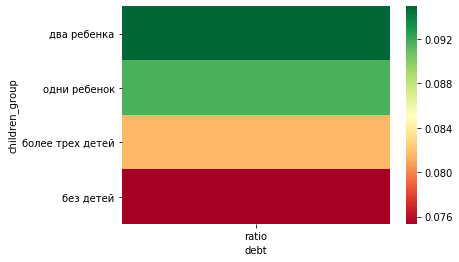

In [39]:
data_children = pivot_table('children_group') # выводим результаты функции pivot_table(index_group) с переменной 'children_group'
data_children['ratio'] = data_children['ratio'].apply('{:.1%}'.format) #изменяем формат столбца 'ratio' на проценты
data_children

**Вывод**

Возврат кредита в срок меньше в категориях - `два ребенка` и `один ребенок`. Категория `без детей` берет больше всего кредитов, этот показатель больше 60%. Но имеет самый низкий показатель по невозврату кредита в срок. Гипотеза подтвердилась.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

debt,False,True,ratio
family_status,,,
Не женат / не замужем,2536,274,9.8%
гражданский брак,3775,388,9.3%
женат / замужем,11413,931,7.5%
в разводе,1110,85,7.1%
вдовец / вдова,896,63,6.6%


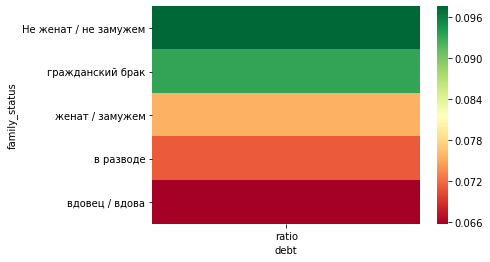

In [40]:
data_family = pivot_table('family_status') # выводим результаты функции pivot_table(index_group) с переменной 'family_status'
data_family['ratio'] = data_family['ratio'].apply('{:.1%}'.format)# изменяем формат столбца 'ratio' на проценты
data_family

**Вывод**

Самой закредитованной категорией является `женат / замужем`. По невозврату кредита в срок лидируют категории  `Не женат / не замужем` и `гражданский брак` .Они имеют более 9% невозврата кредита в срок. Гипотеза подтвердилась.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

debt,False,True,ratio
income_group,,,
доход ниже медианы,9827,908,8.5%
доход выше медианы,9903,833,7.8%


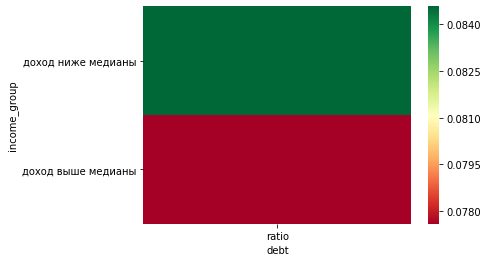

In [41]:
data_income = pivot_table('income_group') # выводим результаты функции pivot_table(index_group) с переменной 'income_group'
data_income['ratio'] = data_income['ratio'].apply('{:.1%}'.format) # изменяем формат столбца 'ratio' на проценты
data_income

**Вывод**

Зависимость уровня дохода и возврата кредита в срок прослеживается небольшая. В связи с тем ,что данные изначально были в столбце `total_income` пропушены и заменили их на медианное значение. Можно предположить,что  полученный результат недостоверный. Гипотеза частично подтвердилась.

- Как разные цели кредита влияют на его возврат в срок?

debt,False,True,ratio
purpose_group,,,
автомобиль,3905,403,9.4%
образование,3644,370,9.2%
свадьба,2149,186,8.0%
недвижимость,10032,782,7.2%


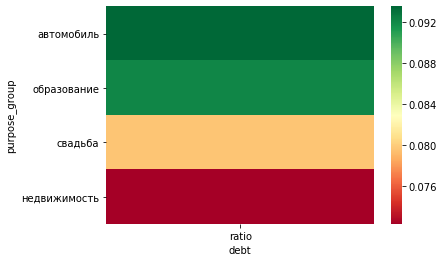

In [42]:
data_purpose = pivot_table('purpose_group') # выводим результаты функции pivot_table(index_group) с переменной 'purpose_group'
data_purpose['ratio'] = data_purpose['ratio'].apply('{:.1%}'.format) # изменяем формат столбца 'ratio' на проценты
data_purpose

**Вывод**

Цели кредита влияют на погашение кредита в срок. В категориях `автомобиль` и `образование` невозврат кредита в срок можно увидеть чаще, нежели в категории `недвижимость`. гипотеза подтвердилась.

## Шаг 4. Общий вывод

В данном исследовании проверели четыре гипотезы и установили:

1. Есть ли зависимость между наличием детей и возвратом кредита в срок?

Наличие детей влияет на выплату кредита в срок.
Гипотеза подтвердилась.

2. Есть ли зависимость между семейным положением и возвратом кредита в срок?

Клиент находящийся или состоял в официальных отношениях возвращает кредит в срок чаще.
Гипотеза подтвердилась.

3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Зависимость прослеживается небольшая. Этот результат мог бы оказаться другим , если бы не было пропусков в даннных.
Гипотеза подтвердилась частично.

4. Как разные цели кредита влияют на его возврат в срок?

Прослеживается зависимость цели кредита и его возврата в срок. Клиенты,взявшие кредит на операции с недвижемостью чаще выплачивают кредит в установленный срок.
Гипотеза подтвердилась.


Оптимальный клиент, при текущих условиях, для банка:
* без детей;
* женат / замужем / в разводе / вдовец / вдова;
* цель кредита: 'недвижимость'.